In [12]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
import pandas as pd
import os
from typing import Callable, Optional, List, Union
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models import resnet50, ResNet50_Weights

pd.set_option("display.max_columns", None)  # Показывает все столбцы
pd.set_option("display.width", 1000)  # Ширина вывода (в символах)
pd.set_option("display.max_colwidth", 150)  # Макс. ширина одного столбца


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Подготовка данных для обучения**

In [3]:
image_dir='/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/images'
label_dir='/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/labels'

In [4]:
# Сбор путей к изображениям и разметке в датафрейм
def create_dataframe(image_dir: Path, label_dir: Path) -> pd.DataFrame:
    data = []

    # Сбор всех изображений
    for image_path in image_dir.glob('**/*.jpg'):
        stem = image_path.stem  # Имя файла без расширения
        label_path = label_dir / f"{stem}.txt"  # Путь к соответствующему файлу разметки

        if label_path.exists():
            data.append({
                'image_path': str(image_path),
                'label_path': str(label_path)
            })

    return pd.DataFrame(data)

image_dir = Path(image_dir)
label_dir = Path(label_dir)
dataset = create_dataframe(image_dir, label_dir)

print(f"Найдено {len(dataset)} пар изображение-метка")

Найдено 100 пар изображение-метка


In [5]:
dataset.head()

,image_path,label_path
0,/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/images/7_frame_0032.jpg,/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/labels/7_frame_0032.txt
1,/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/images/6_frame_0044.jpg,/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/labels/6_frame_0044.txt
2,/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/images/1_frame_0038.jpg,/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/labels/1_frame_0038.txt
3,/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/images/8_frame_0014.jpg,/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/labels/8_frame_0014.txt
4,/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/images/7_frame_0050.jpg,/content/drive/MyDrive/Учеба/ITMO/CV_Adv/data/labels/7_frame_0050.txt


In [6]:
# Класс формаирования датасета
class YOLOv1Dataset(Dataset):
    def __init__(
    self,
    image_dir: str,
    label_dir: str,
    grid_size: int = 7,
    num_boxes: int = 2,
    num_classes: int = 20,
    transform: Optional[Callable] = None
) -> None:
        self.image_dir = Path(image_dir)
        self.label_dir = Path(label_dir)
        self.grid_size = grid_size
        self.num_boxes = num_boxes
        self.num_classes = num_classes
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((448, 448))
        ])

        # Собираем все валидные пары изображение-разметка
        self.samples = []
        for img_path in self.image_dir.glob('*'):
            if img_path.suffix.lower() in ['.jpg', '.png', '.jpeg']:
                label_path = self.label_dir / f"{img_path.stem}.txt"
                if label_path.exists() and os.path.getsize(label_path) > 0:
                    self.samples.append((img_path, label_path))

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx) -> dict:
      img_path, label_path = self.samples[idx]

      # Загрузка изображения
      image = cv2.imread(str(img_path))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Инициализация матрицы разметки
      label_matrix = torch.zeros((self.grid_size, self.grid_size, self.num_boxes*5 + self.num_classes))

      # Чтение аннотаций
      with open(label_path, 'r') as f:
          lines = [line.strip() for line in f.readlines() if line.strip()]

      for line in lines:
          parts = line.split()
          if len(parts) != 5:
              continue

          class_id, x_center, y_center, width, height = map(float, parts)
          class_id = int(class_id)

          # Определение grid cell
          grid_x = int(x_center * self.grid_size)
          grid_y = int(y_center * self.grid_size)

          # Координаты относительно ячейки
          x_cell = (x_center * self.grid_size) - grid_x
          y_cell = (y_center * self.grid_size) - grid_y

          # Заполнение ПЕРВОГО доступного bbox'а в ячейке
          for b in range(self.num_boxes):
              if label_matrix[grid_y, grid_x, b*5 + 4] == 0:  # Если confidence=0
                  label_matrix[grid_y, grid_x, b*5:(b+1)*5] = torch.tensor([
                      x_cell, y_cell, width, height, 1.0
                  ])
                  label_matrix[grid_y, grid_x, self.num_boxes*5 + class_id] = 1.0
                  break

      # Применение трансформаций
      image = self.transform(image)

      return image, label_matrix


In [7]:
# Формирование датасета
dataset = YOLOv1Dataset(
    image_dir=image_dir,
    label_dir=label_dir,
    grid_size=7,
    num_boxes=2,
    num_classes=2
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [8]:
# Проверка первого батча
batch = next(iter(dataloader))
images, labels = batch
print("Первый батч - images:", images.shape, "labels:", labels.shape)

Первый батч - images: torch.Size([16, 3, 448, 448]) labels: torch.Size([16, 7, 7, 12])


In [9]:
# Визуализация разметки
def plot_all_bboxes(
    image_tensor: torch.Tensor,
    label_matrix: torch.Tensor,
    class_names: Optional[List[str]] = None
) -> None:

    # Денормализация изображения
    image = image_tensor.permute(1, 2, 0).numpy()
    image = np.clip(image, 0, 1)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    grid_size = label_matrix.shape[0]
    h, w = image.shape[:2]
    cell_size_h = h / grid_size
    cell_size_w = w / grid_size

    colors = plt.cm.tab10.colors  # 10 различных цветов

    count = 0

    for i in range(grid_size):
        for j in range(grid_size):
            # Проверяем все bbox'ы в ячейке
            for b in range(2):  # YOLOv1 использует 2 bbox'а

                box_data = label_matrix[i, j, b*5:(b+1)*5]
                class_probs = label_matrix[i, j, 10:]  # 2*5=10

                # Если confidence > 0 (даже 0.1 для надежности)
                if box_data[4] > 0.001:
                    count += 1 # счет bbox'ов

                    x_center, y_center, box_w, box_h, conf = box_data

                    # Абсолютные координаты
                    x_center_abs = (j + x_center) * cell_size_w
                    y_center_abs = (i + y_center) * cell_size_h
                    box_w_abs = box_w * w
                    box_h_abs = box_h * h

                    # Координаты углов с проверкой границ
                    x1 = max(0, x_center_abs - box_w_abs/2)
                    y1 = max(0, y_center_abs - box_h_abs/2)
                    x2 = min(w, x_center_abs + box_w_abs/2)
                    y2 = min(h, y_center_abs + box_h_abs/2)

                    # Определение класса
                    class_id = torch.argmax(class_probs).item()
                    class_name = class_names[class_id] if class_names else f'Class {class_id}'
                    color = colors[class_id % len(colors)]

                    # Рисуем bbox
                    rect = patches.Rectangle(
                        (x1, y1), x2 - x1, y2 - y1,
                        linewidth=2, edgecolor=color, facecolor='none',
                        # linestyle='-' if b == 0 else '--'
                    )
                    ax.add_patch(rect)

                    # Подпись с confidence
                    plt.text(
                        x1, y1 - 5, f'{class_name} {conf:.2f}',
                        color='white', fontsize=10, weight='bold',
                        bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=0)
                    )

    print(f"Найдено bbox'ов: {count}")  # Должно совпадать с количеством строк в файле разметки
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Найдено bbox'ов: 22


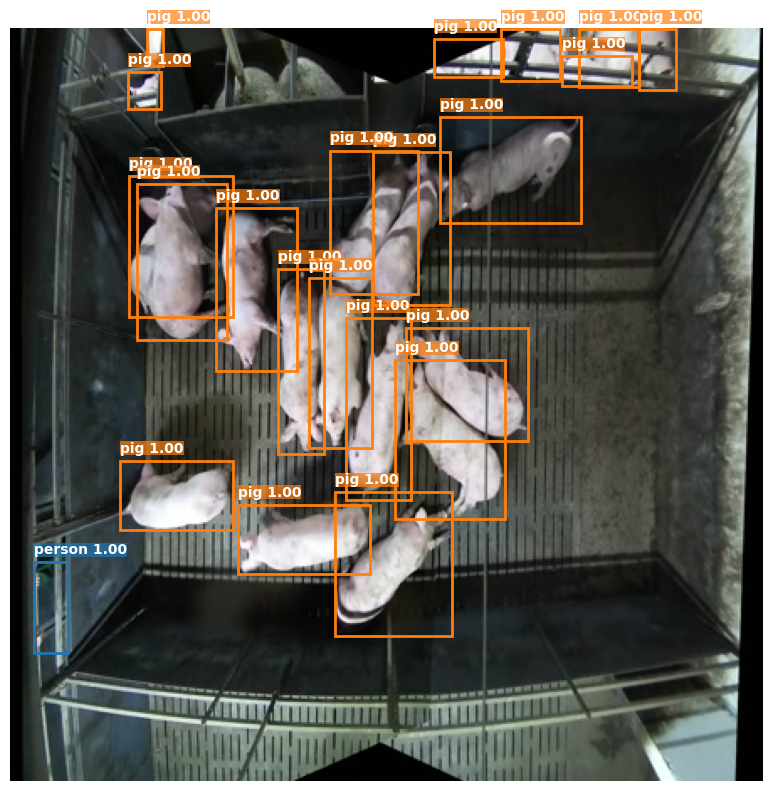

In [10]:
# Загружаем один батч
image, label = next(iter(dataloader))

# Выбираем первое изображение и его разметку
img_tensor = images[0]  # [C, H, W]
label_matrix = labels[0]  # [S, S, B*5+C]

# Визуализация
class_names = ['person', 'pig']
plot_all_bboxes(img_tensor, label_matrix, class_names=class_names)

## **Создание архитектуры модели**

In [13]:
# Выбор преобученной модели
backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
# Класс архитектуры модели
class YOLOv1_ResNet50(nn.Module):
    def __init__(self, backbone=backbone, grid_size=7, num_boxes=2, num_classes=2):
        super(YOLOv1_ResNet50, self).__init__()
        self.grid_size = grid_size
        self.num_boxes = num_boxes
        self.num_classes = num_classes

        # Backbone: ResNet50 (без последнего FC слоя)
        self.backbone = backbone
        self.backbone = nn.Sequential(*list(self.backbone.children()))[:-2]  # Удаляем avgpool и FC

        # 4 дополнительных слоя как в оригинале (с адаптацией для 2048 каналов)
        self.extra_layers = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),

            # Conv Block 2 (с уменьшением размера до 7x7)
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),

            # Conv Block 3
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),

            # Conv Block 4
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1)
        )

        # Полносвязные слои
        self.fc = nn.Sequential(
            nn.Linear(1024 * grid_size * grid_size, 4096),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(4096, grid_size * grid_size * (num_boxes * 5 + num_classes))
        )

    def forward(self, x):
        # Проверка входа 448x448
        if x.size(2) != 448 or x.size(3) != 448:
            raise ValueError("Input must be 448x448")

        # Forward pass
        x = self.backbone(x)          # [B, 2048, 14, 14]
        x = self.extra_layers(x)      # [B, 1024, 7, 7]

        # Проверка размера перед FC
        if x.size(2) != self.grid_size or x.size(3) != self.grid_size:
            raise RuntimeError(f"Expected {self.grid_size}x{self.grid_size}, got {x.size(2)}x{x.size(3)}")

        x = x.flatten(1)              # [B, 1024*7*7]
        x = self.fc(x)                # [B, 7*7*(5*2+2)]
        return x.view(-1, self.grid_size, self.grid_size, self.num_boxes*5 + self.num_classes)

In [34]:
# Модель
model = YOLOv1_ResNet50(backbone=backbone, grid_size=7, num_boxes=2, num_classes=2)

test_input = torch.randn(2, 3, 448, 448)  # [batch_size, channels, height, width]
output = model(test_input)
print(output.shape)  # [batch_size, grid_size, grid_size, B*5 + C] - [2, 7, 7, 12]

torch.Size([2, 7, 7, 12])
